# 北京PM2.5分析与预测

背景：北京与中国大部分地区仍在经历长期的空气污染，受PM2.5影响最甚。PM2.5会严重影响到人们的身体健康，对PM2.5进行监测与研究是十分必要的。其中，PM2.5含量与天气相关是常识性的。因此研究PM2.5与天气的关系是有效且重要的。本项目通过对2010至2014年北京的PM2.5含量与天气状况进行分析，回归，以得到对PM2.5含量的预测模型及回归结论。

## 数据预处理

### 导入数据

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_raw = pd.read_csv("./PRSA_data.csv")

### 删除遗失PM2.5的数据（“nan”）

In [3]:
df = df_raw.dropna(subset=['pm2.5']).copy()

### 选择训练集与测试集
根据要求，我们使用2010-01-01到2014-12-31中每周周四的数据作为测试集，其余数据用作训练。我们用函数`find_weekday()`判断日期所在的星期，该函数的原理为蔡勒(Zeller)公式, 形式如下：
$$\begin{aligned} W &= \left[ \frac{c}{4} \right] - 2c + y + \left[ \frac{y}{4} \right] + \left[ \frac{13(m+1)}{5} \right] + d - 1 \\[2ex] D &= W \bmod 7 \end{aligned}$$
其中$D$是星期数，$c$是世纪数减1，也就是年份的前两位，$y$是年份的后两位，$m$是月份（$m$的取值范围为3-14，将某年的1、2月要看作上一年13、14月），$d$是日数，[]是向下取整运算，mod是取余运算。

有了`find_weekday()`之后，我们再通过`determine_test()`函数来判断某一日期是否是周四，也就是测试集数据。

In [4]:
import math

def find_weekday(year,month,day):
    year = year-2000
    c = 20
    w = 0    
    if month == 1:
        month = 13
        year = year-1
    if month == 2:
        month = 14
        year = year-1
    w = year + math.floor(year/4) + math.floor(c/4) -2*c +math.floor(26*(month+1)/10) + day -1
    return w%7

def determine_test(year,  month, day):
    w= find_weekday(year,month,day)
    if w == 4 :
        return 1
    else:
        return 0


In [5]:
determine_test(2014,12,25)

1

In [6]:
df['week']=df.apply(lambda x: find_weekday(x['year'],x['month'],x['day']), axis=1)

将`df`的`'year','month','day'`列作用定义的`determine_test()`函数，即可得到数据是否作为测试集的属性`test`.

In [7]:
df['test'] =df.apply(lambda x: determine_test(x['year'],x['month'],x['day']), axis=1)
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,week,test
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,6,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,6,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,6,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,6,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,3,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,3,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,3,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,3,0


### 数据归一化和将特征`'cbwd'`转为one-hot编码

由于之后将要比较特征之间的重要性，我们将用归一化后的数据做回归。我们采用的归一化方法为z-score归一化，即将每一列数值型变量做标准化（标准化的意思是减去其均值，除以其方差）。

除了对于数值型数据的归一化，我们还要将类别型数据，这里只有`'cbwd'`(风向)，转化为one-hot编码。这里采用one-hot的编码的原因是类别型数据没有大小关系，作回归时我们将采用普通的欧式距离，因此不希望不同类别对回归造成影响。

In [8]:
def add_normalized_data(df):
    real_number_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
    for col in real_number_cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)


add_normalized_data(df)
df_dummy = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df,df_dummy], axis=1)
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,DEWP_zscore,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,...,-1.229791,-1.347143,0.345329,-0.444944,-0.071057,-0.137408,0,0,1,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,...,-1.160508,-1.347143,0.345329,-0.427007,-0.071057,-0.137408,0,0,1,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,...,-0.883375,-1.429278,0.442411,-0.409069,-0.071057,-0.137408,0,0,1,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,...,-0.606241,-1.429278,0.539493,-0.372993,1.212862,-0.137408,0,0,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,...,-0.606241,-1.429278,0.539493,-0.355055,2.496781,-0.137408,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,-1.714775,-1.182873,1.704472,4.194201,-0.071057,-0.137408,0,1,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,-1.645491,-1.265008,1.704472,4.311298,-0.071057,-0.137408,0,1,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,-1.645491,-1.265008,1.704472,4.410458,-0.071057,-0.137408,0,1,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,-1.645491,-1.347143,1.704472,4.491479,-0.071057,-0.137408,0,1,0,0


### 将训练集、测试集赋予名称
经过了上述步骤，我们实际上已经得到了训练、测试所需的所有数据。不过为了代码的方便，我们将训练集测试集分别赋予不同的名称。训练集的`DataFrame`称为`train`, 测试集则为`test`. 训练数据的特征集为`X_train_normalized_data`, label 为`y_train_data`, 测试集的命名同理类似。 

In [9]:
df['test'] =df.apply(lambda x: determine_test(x['year'],x['month'],x['day']), axis=1)
test = df.loc[df['test'] == 1]
train = df.loc[df['test'] == 0]

In [10]:
name_feature = ['DEWP', 'TEMP', 'PRES','Iws', 'Is', 'Ir']
name_feature_z_score=['DEWP_zscore', 'TEMP_zscore', 'PRES_zscore','Iws_zscore', 'Is_zscore', 'Ir_zscore']
name_cbwd=['cbwd_NE', 'cbwd_NW', 'cbwd_SE','cbwd_cv']
X_train_normalized_data = train.loc[:,name_feature_z_score+name_cbwd]
X_test_normalized_data = test.loc[:,name_feature_z_score+name_cbwd]
X_train_raw_data = train.loc[:,name_feature+name_cbwd]
X_test_raw_data = test.loc[:,name_feature+name_cbwd]

y_train_data = train.loc[:,'pm2.5']
y_test_data = test.loc[:,'pm2.5']

## 回归：Part I

在这一部分中，我们只使用样本的天气数据，不使用和时间相关的数据。


### 天气数据、PM2.5数据可视化



PM2.5的分布函数大概如下图所示，可以看到是一个双峰的分布，也就是说，PM2.5并不是独立地从同一个分布中采样，否则根据大数定律，应该服从正态分布。

Text(0, 0.5, '')

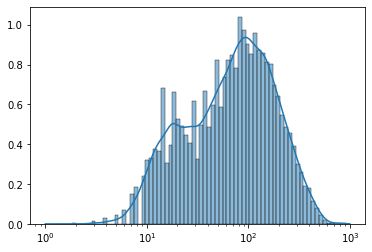

In [10]:
sns.histplot(data=df['pm2.5'].values+1,log_scale=True,kde=True,stat='density')
plt.ylabel('')

下面六个分布函数展示了天气数据的分布情况，可以看到DEWP,TEMP,PRES三个的取值比较均衡，而lws,ls,lr三个的取值没有太大变化，基本位于均值附近。

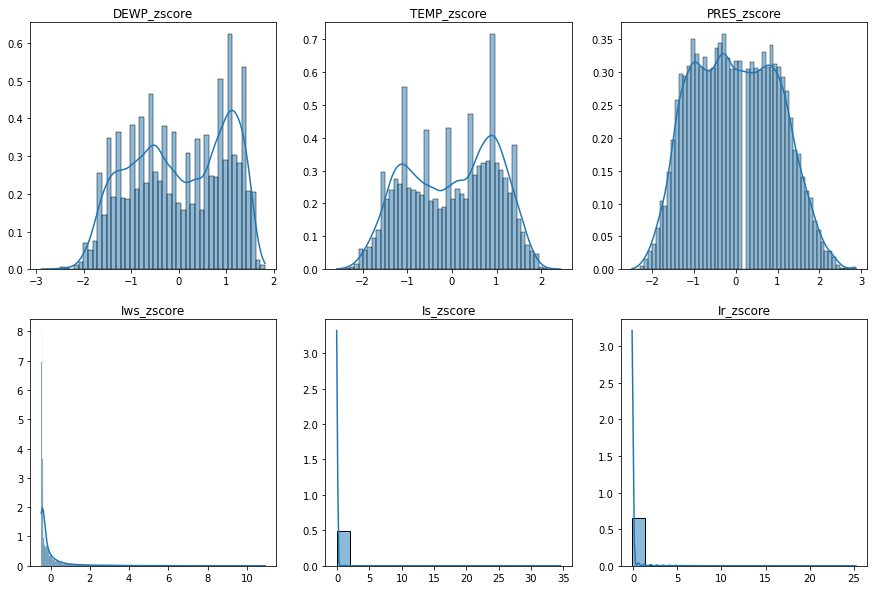

In [11]:
fig=plt.figure(figsize=(15,10))
i=1
for feature in name_feature_z_score:
    ax=plt.subplot(2,3,i)
    sns.histplot(data=df[feature].values,kde=True,stat='density')
    plt.ylabel('')
    plt.title(feature)
    i+=1

下面六张图粗略地展示了PM2.5随天气情况的变化，可以发现与PM2.5相关性比较强的是DEWP, Iws, Ir. 在重要特征的分析中，这三个特征或许将会是重要特征。

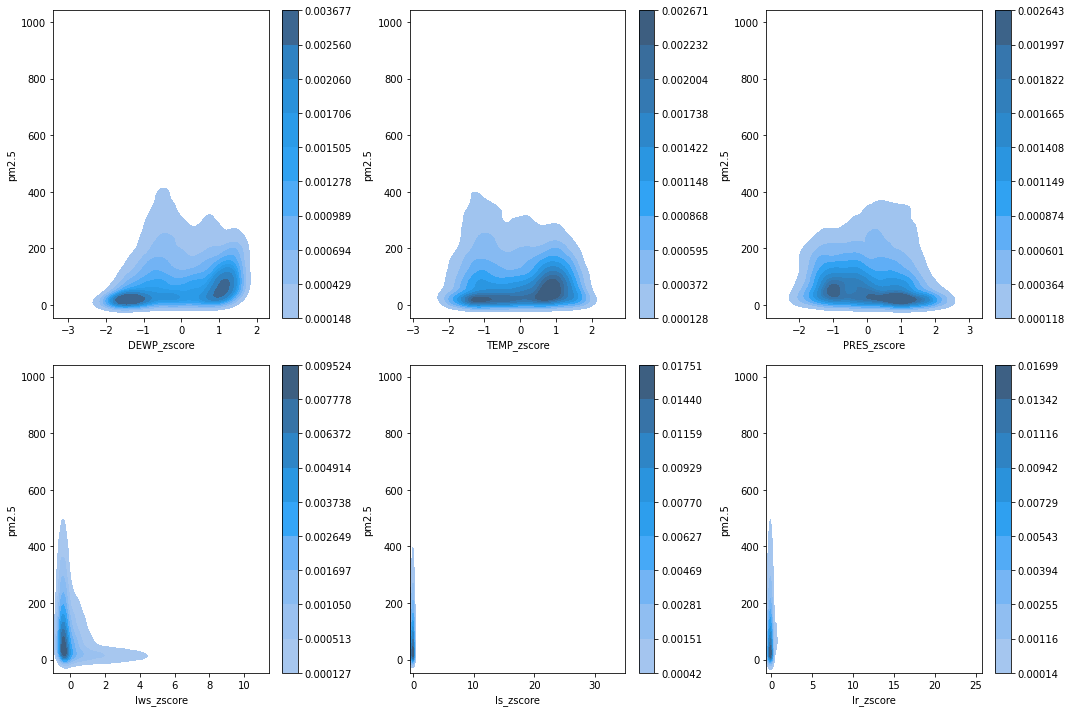

In [12]:
fig=plt.figure(figsize=(15,10))
i=1
for feature in name_feature_z_score:
    ax=plt.subplot(2,3,i)
    sns.kdeplot(x=df[feature],y=df['pm2.5'],cbar=True,shade=True)
    i+=1
fig.tight_layout()
plt.show()

最后，我们展示cbwd的分布情况和一张pm2.5和cbwd的关系。

<AxesSubplot:xlabel='cbwd', ylabel='pm2.5'>

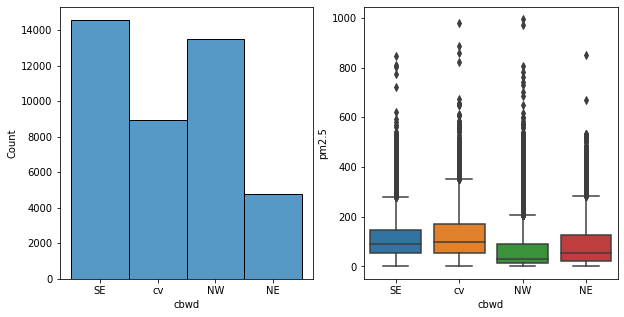

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax2=sns.histplot(df['cbwd'])
plt.subplot(1,2,2)
sns.boxplot(x=df['cbwd'],y=df['pm2.5'])

### 模型的评价标准：R2 score, Adjusted R2 score, Mean Square Error (MSE).
对于回归模型，我们采用三个评价标准来评价模型预测的好坏，分别是：R2 score, Adjusted R2 score, Mean Square Error (MSE). 主要采用的评价标准是Adjusted R2 score, 因为我们之后会对数据添加更多的特征，而普通的R2 score有一个特点，即对于特征维数越大的数据，其评价分数越高，而Adjusted R2 score消除了特征维数的影响。R2 score转化为 Adjusted R2 score的公式为：
$$
\text{Adjusted\_}R^2 = 1-\frac{(1-R^2)(n-1)}{n-p-1},
$$
其中$n$是样本的个数，$p$是特征的维数。R2 score和 MSE 在`sklearn`模块中有预先定义的函数，这里只需重新定义Adjusted R2 score, 定义为`adj_R2_score()`.


In [16]:
# model assessment
def adj_R2_score(model, X, y):
    return 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

### 使用的回归模型：LinearRegression, Ridge, Lasso, SVR, XGBoost.

我们使用上述几种模型做这个回归问题，之后我们将单独使用KNN做数据填补，因此在这里不涉及。另外，不涉及决策树算法和其它集成方法的原因是我们认为XGBoost算法包含了这些算法。

我们使用的LinearRegression, Ridge 和 Lasso都取自`sklearn.linear_model`模块, 使用的XGBoost取自`xgboost`模块。之所以使用XGBoost的方法是因为在集成方法中，GBDT方法的效果较好，然而运算速度较慢。而XGBoost方法通过多线程并行计算和加速算法，很好得提升了GBDT的性能和速度，所以我们采用了XGBoost算法。需要注意的是，除了LinearRegression之外，其它三个方法都有超参数需要确定，我们采用对训练集交叉验证(Cross-Validation,CV)的方法找出最佳的超参数（我们选取了10折的交叉验证）。对于XGBoost,由于有多个超参数，我们使用网格交叉验证，也就是讲高维空间的划分为网格，每一个格点都算出一个平均误差，取平均误差最小的点. 

实际上，Ridge和Lasso都有自带交叉验证的模块：`RidgeCV`和`LassoCV`, 所以我们只需要在使用XGBoost之前调用`GridSearchCV`模块做CV即可。

由于代码的相似性，我们将训练模型的过程和结果可视化的写成了循环的形式，并封装为`fit_plot_result()`，使得代码的简洁，利于修改，也方便我们可以对比不同方法的结果. 

In [14]:
from sklearn.metrics import mean_squared_error
from time import time

def fit_plot_result(regression_algorithms,X_train,y_train,X_test,y_test):
    
    plot_num=1
    fig=plt.figure(figsize=(16,10))
    fig.suptitle('Visualization of Result')
    result_df = pd.DataFrame(columns=['Algorithm','Adj_R2 of test','R2 of train','R2 of test','MSE of test'])
    for name,algorithm in regression_algorithms:
        t0=time()
        algorithm.fit(X=X_train,y=y_train)
        y_pred=algorithm.predict(X_test)
        t1=time()
        r2_train = algorithm.score(X_train,y_train)
        r2_test = algorithm.score(X_test,y_test)
        r2_adj_test = adj_R2_score(model=algorithm,X=X_test,y=y_test)
        mse = mean_squared_error(y_true =y_test,y_pred=y_pred)
        result_df.loc[plot_num-1]=[name,r2_adj_test,r2_train,r2_test,mse]
        
        ax=fig.add_subplot(2,3,plot_num)
        ax.margins(0)
        sns.scatterplot(x=y_pred, y=y_test, s=2, color=".15")
        sns.histplot(x=y_pred, y=y_test, bins=50, pthresh=.1, cmap="Oranges")
        sns.kdeplot(x=y_pred, y=y_test, levels=5, color="orange", linewidths=1)
        x=np.arange(0,300,0.1)
        y=x
        plt.plot(x,y,label='line $y=x$')
        plt.legend()
        plt.xlabel("Predicted PM2.5")
        plt.ylabel("Real PM2.5")
        plt.title('Algorithm: {}, which takes {} seconds'.format(name,round(t1-t0,2)))
        plot_num+=1
    fig.tight_layout()
    plt.show()
    return result_df

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Never run it again, take 23 minutes to run.
'''
tuned_parameters = {'booster':['gbtree'],
                    'max_depth': range(3,10),
                    'gamma':[0],
                    'n_estimators':[100,200,300,400],
                    'learning_rate' : [0.1,0.2],
                    'colsample_bytree':[0.8,1]
                     }

clf = GridSearchCV(XGBRegressor(), tuned_parameters, cv=5)
clf.fit(X_train_normalized_data,y_train_data)
clf.best_estimator_
'''
'''
Result:
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
'''

"\nResult:\nXGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n             early_stopping_rounds=None, enable_categorical=False,\n             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n             importance_type=None, interaction_constraints='',\n             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,\n             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,\n             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n             reg_lambda=1, ...)\n"

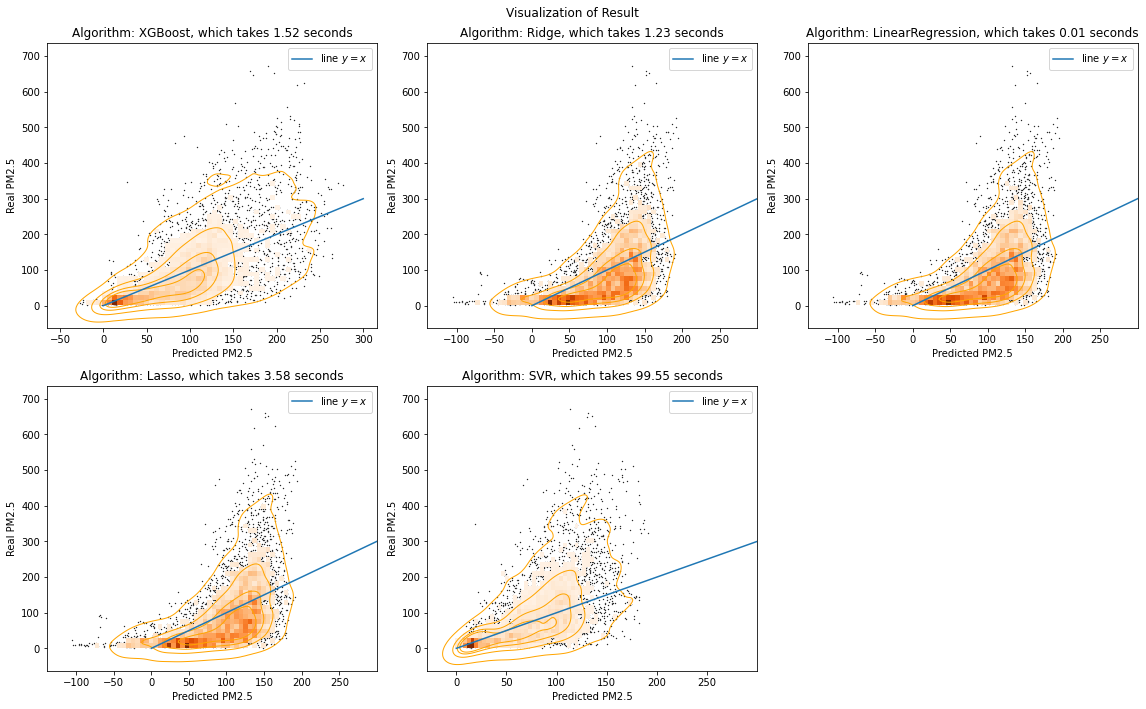

In [17]:
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

# 由于SVR, 将会运行大约四分钟

linear_model=LinearRegression()
ridge_cv=RidgeCV(alphas=np.arange(0.0001,0.001,0.0001),cv=10)
lasso_cv=LassoCV(alphas=np.arange(0.01,10,0.01),cv=10)
svr=SVR(kernel='rbf')
xgb=XGBRegressor(booster='gbtree',max_depth=3,n_estimators=200,learning_rate=0.1)

regression_algorithms={
    ('LinearRegression',linear_model),
    ('Ridge',ridge_cv),
    ('Lasso',lasso_cv),
    ('SVR',svr),
    ('XGBoost',xgb)
}
result_df= fit_plot_result(regression_algorithms=regression_algorithms,X_train=X_train_normalized_data,\
    y_train=y_train_data,X_test=X_test_normalized_data,y_test=y_test_data)

（数据可视化图像解释：对于每一个子图，图中的每一个点代表一个测试集中的样本，对应横轴代表预测的PM2.5的值，纵轴代表其真实的PM2.5标签。蓝线代表横轴和纵轴相等，即预测值等于真实值。图中，热力图的深浅表示点的密集程度，越深的颜色代表改区域的点密度越大。之后会频繁出现这个图像可视化结果，解释将略。）

我们可以看到，SVR算法训练和预测的时间总和非常高，大约有一分钟，算法效率很差。如果进行交叉验证选取参数则相当耗时，因此我们不对其进行交叉验证选取参数，而是直接舍弃这个算法。在之后的对比中，我们将着重对比线性模型和XGBoost的效果。

另一方面，观察数据可视化的结果，可以看到：线性模型的预测效果非常类似，在实际PM2.5为0-100的区间时，线性模型的预测值会大于真实值；在实际PM2.5为150左右时，模型的预测效果比较好；当实际PM2.5大于200时，线性模型几乎无法正确预测。而对于XGBoost模型，其$R^2$虽然较高，但是它也只在PM2.5的真实值较小时（区间[0,30]）有比较好的预测结果，当PM2.5的真实值大于100后，模型就几乎失去了预测能力。

In [18]:
result_df

,Algorithm,Adj_R2 of test,R2 of train,R2 of test,MSE of test
0,XGBoost,0.412286,0.407917,0.413264,4998.699426
1,Ridge,0.275152,0.257725,0.276358,6165.064424
2,LinearRegression,0.275288,0.257688,0.276494,6163.909507
3,Lasso,0.275072,0.257717,0.276278,6165.749472
4,SVR,0.289058,0.261381,0.290240,6046.795802


可以看到，线性模型：LinearRegression, Ridge 和 Lasso的结果不论从数据可视化还是从误差来看都相差无几，并且效果都不是很好。因此我们推断，pm2.5的值和天气因素的关系是非线性的，故选取XGBoost作为我们的预测模型，我们的预测模型结果包含在了上表中。

## 回归：Part II

在这一部分中，我们的回归不在局限于使用样本的天气数据，还将使用与时间相关的数据。


### 探究PM2.5变化趋势与时间的关系
我们想通过数据可视化的方式，找到PM2.5关于时间的大致规律，再将这些规律加入样本，以使得回归模型有更高的精度。我们先来看PM2.5的值和小时、星期、月份、年份的关系。

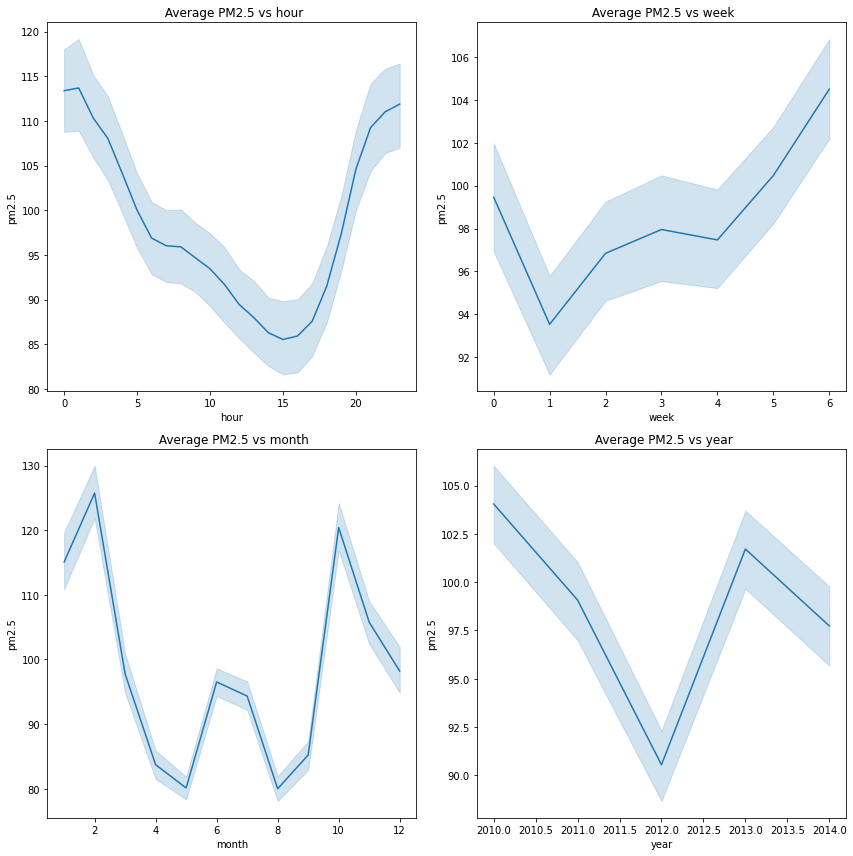

In [19]:
fig = plt.figure(figsize=(12,12))

times = ['hour','week','month','year']

i=1
for time in times:
    ax = plt.subplot(2,2,i)
    sns.lineplot(x=df[time],y=df['pm2.5'])
    plt.title(' Average PM2.5 vs {}'.format(time))
    i+=1

fig.tight_layout()
plt.show()

从上方可视化结果来看，PM2.5关于小时的关系比较明显，我们于是将一天按照小时分为三个部分：早晨（5-11），中午（12-17），晚上（18-5）. 类似地，从星期情况可以看到，PM2.5在周末，即星期五、六、天的浓度较高，因此将星期划分为：周末（5-7）和周中（1-4）. 我们对于月份，按照季节自然划分，也可以看到在1-2,10-12月时，PM2.5浓度较高，在3-9月则较低，这正对应着秋冬浓度较高、春夏浓度较低。因此，我们对于季节的划分为春季（3-5），夏季（6-9），秋季（10-11），冬季（12，1-2）. 最后，按照年来看，我们意外地发现2012年的年平均PM2.5相比其余四个年份较低，因此将年份划分为2012年和其它。

另一方面，我们还将政策因素和日常因素纳入了考虑。由于在春节期间，我国放鞭炮的传统习俗，通常来说PM2.5浓度会较高，因此添加是否是春节时间的特征`spring_festival`. 另外，每当北京在开两会的时候，空气质量会受到政策调控的影响而变得较好，于是我们添加了特征`meeting`, 将召开两会和一次APEC会议的日期的`meeting`设为1.

最后，仿照模型回归：Part I 中的做法，我们将新的数据做了数据归一化，并将新的训练数据称为`X_train_plus_time_data`，新的测试数据称为`X_test_plus_time_data`. 标签PM2.5的浓度自然还是与原来相同。

In [11]:
def if_spring(month):
    return int(3<= month<=5)
def if_summer(month):
    return int(6<= month<=9)
def if_fall(month):
    return int(10<= month<=11)
def if_winter(month):
    if month ==12:
        return 1
    elif 1<=month <=2:
        return 1
    else:
        return 0
def if_weekend(week):
    return int(not(1<= week<= 4))
def if_morning(hour):
    return int(5<=hour<=11)
def if_afternoon(hour):
    return int(12<=hour<=17)
def if_night(hour):
    return int(not (5<=hour<=17))
def if_2012(year):
    return int(year==2012)
def if_spring_festival(year,month,day):
    flag=0
    if year == 2010:
        if month == 2:
            if 14<=day<=21:
                flag =1
    elif year == 2011:
        if month == 2:
            if 3<=day <=10:
                flag =1
    elif year == 2012:
        if month ==1:
            if 23<=day<=30:
                flag =1
    elif year == 2013:
        if month == 2:
            if 10<=day<=17:
                flag =1
    elif year ==2014:
        if month == 1:
            if day==31:
                flag= 1
        if month ==2:
            if 1<=day<=6:
                flag= 1
    return flag
def if_meeting(year,month,day):
    flag=0
    # 两会
    
    if year == 2010:
        if month ==3:
            if 5<=day<=14:
                flag=1
    if year == 2011:
        if month ==3:
            if 3<=day<=14:
                flag=1
    if year == 2012:
        if month ==3:
            if 5<=day<=14:
                flag=1
    if year == 2013:
        if month ==3:
            if 5<=day<=17:
                flag=1
    if year == 2014:
        if month ==3:
            if 5<=day<=13:
                flag=1
    
    
    # APEC
    if year == 2014:
        if month ==11:
            if 5<=day<=11:
                flag=1
    return flag
df['spring'] =df.apply(lambda x: if_spring(x['month']), axis=1)
df['summer'] =df.apply(lambda x: if_summer(x['month']), axis=1)
df['fall']=df.apply(lambda x: if_fall(x['month']), axis=1)
df['winter']=df.apply(lambda x: if_winter(x['month']), axis=1)
df['weekday']=df.apply(lambda x: if_weekend(x['week']), axis=1)
df['morning']=df.apply(lambda x: if_morning(x['hour']), axis=1)
df['afternoon']=df.apply(lambda x: if_afternoon(x['hour']), axis=1)
df['night']=df.apply(lambda x: if_night(x['hour']), axis=1)
df['spring_festival']=df.apply(lambda x: if_spring_festival(x['year'],x['month'],x['day']), axis=1)
df['meeting']=df.apply(lambda x: if_meeting(x['year'],x['month'],x['day']), axis=1)

plus_time_test = df.loc[df['test'] == 1]
plus_time_train = df.loc[df['test'] == 0]
name_plus_time_data=['DEWP_zscore', 'TEMP_zscore', 'PRES_zscore',
       'Iws_zscore', 'Is_zscore', 'Ir_zscore', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'spring', 'summer', 'fall', 'winter', 'weekday',
       'morning','afternoon','night', 
       'spring_festival', 'meeting']
X_train_plus_time_data = plus_time_train.loc[:,name_plus_time_data]
X_test_plus_time_data = plus_time_test.loc[:,name_plus_time_data]





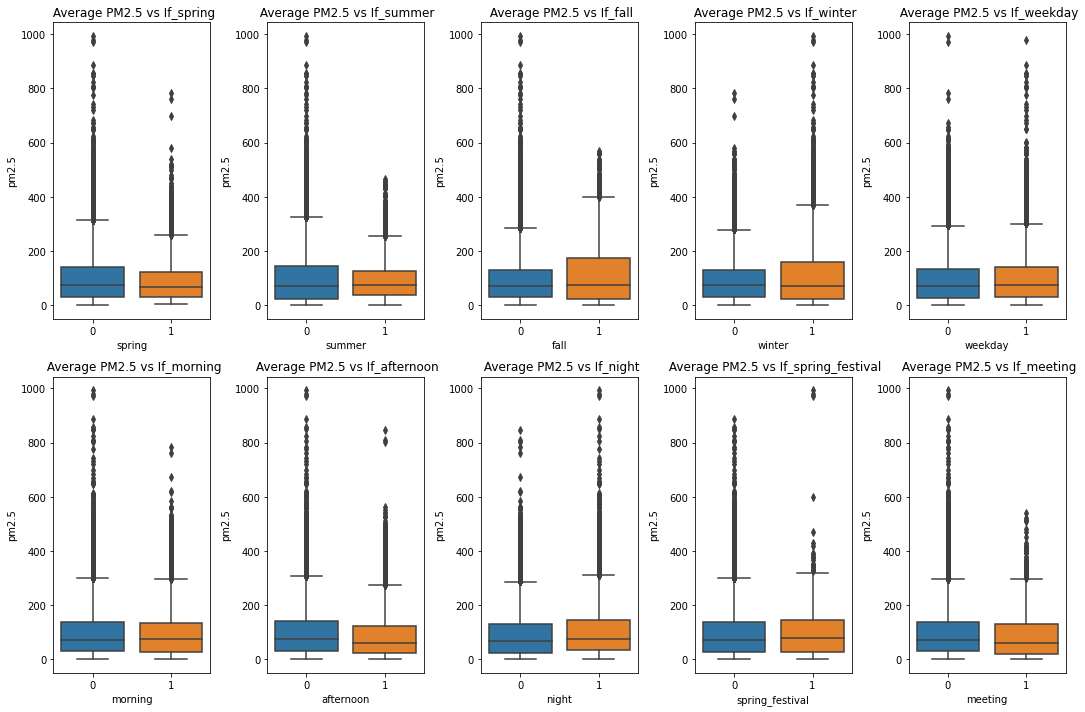

In [21]:
fig=plt.figure(figsize=(15,10))

factors=['spring','summer','fall','winter','weekday','morning','afternoon','night','spring_festival','meeting']
i=1
for factor in factors:
   # df1= df.groupby(factor).agg({'pm2.5':'mean'})
    ax=plt.subplot(2,5,i)
    sns.boxplot(x=df[factor],y=df['pm2.5'])
    plt.title(' Average PM2.5 vs If_{}'.format(factor))
    i+=1
fig.tight_layout()
plt.show()

从上图中可以看出，除了条件“是否是春节”和“是否是早晨”对PM2.5的影响并不大，其它添加的时间特征对PM2.5都有不同程度的影响。

### 对添加了时间特征的数据进行回归预测

这里我们只需要将回归模型：PartI中的代码中的数据进行相应的修改即可（过程同样是CV选择参数、模型建立最后模型结果可视化）。由于我们新增了对PM2.5产生影响的特征，这次回归的结果预期将会好于上一次。

In [22]:
'''
# 需要1分钟时间运行, 更具上一次的经验, 我们减少了CV的的范围
tuned_parameters = {'booster':['gbtree'],
                    'max_depth': range(3,5),
                    'gamma':[0],
                    'n_estimators':[100,200],
                    'learning_rate' : [0.1,0.2]
                     }

clf = GridSearchCV(XGBRegressor(), tuned_parameters, cv=5)
clf.fit(X_train_plus_time_data,y_train_data)
clf.best_estimator_
'''

'''
Result:
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
'''

"\nResult:\nXGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n             early_stopping_rounds=None, enable_categorical=False,\n             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n             importance_type=None, interaction_constraints='',\n             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,\n             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,\n             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n             reg_lambda=1, ...)\n"

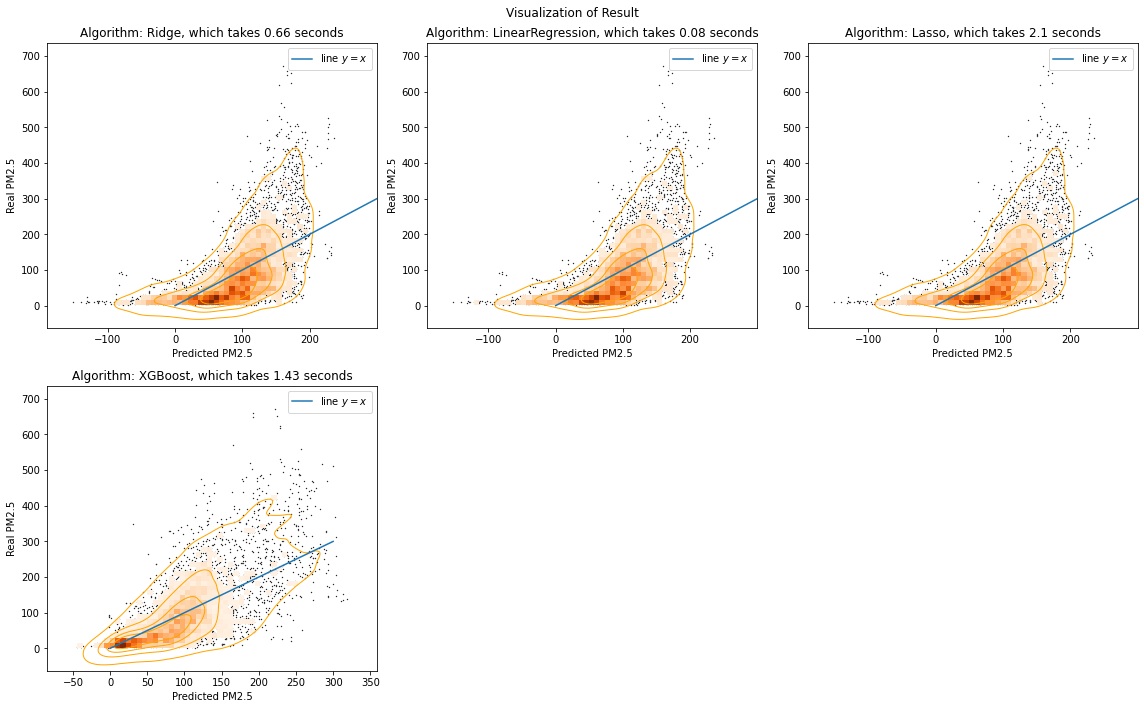

In [17]:
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from time import time
import seaborn as sns

linear_model=LinearRegression()
ridge_cv=RidgeCV(alphas=np.arange(0.0001,0.001,0.0001),cv=10)
lasso_cv=LassoCV(alphas=np.arange(0.01,10,0.01),cv=10)
xgb=XGBRegressor(booster='gbtree',max_depth=3,n_estimators=200,learning_rate=0.1)

regression_algorithms={
    ('LinearRegression',linear_model),
    ('Ridge',ridge_cv),
    ('Lasso',lasso_cv),
    ('XGBoost',xgb)
}

result_plus_time_df =fit_plot_result(regression_algorithms=regression_algorithms,\
                X_train=X_train_plus_time_data,\
                y_train=y_train_data,\
                X_test=X_test_plus_time_data,\
                y_test=y_test_data)

In [24]:
result_plus_time_df

,Algorithm,Adj_R2 of test,R2 of train,R2 of test,MSE of test
0,XGBoost,0.491742,0.512079,0.493433,4315.695795
1,Lasso,0.343346,0.340220,0.345532,5575.743193
2,Ridge,0.343338,0.340222,0.345523,5575.817591
3,LinearRegression,0.343165,0.340157,0.345351,5577.283621


可以看到，不论是线性模型还是集成模型XGBoost，效果都明显提高了，这个我们的预期是一致的。从数据可视化的结果可以看出，在没有加入时间特征之前，XGBoost只能在真实的PM2.5较小时有比较好的预测结果，在添加了时间特征之后，它能对较大范围（区间[0,100]效果很好，[100,200]效果次之）的PM2.5值进行比较好的预测了。

## 回归模型：Part III

在这一部分中，我们对处理缺失值的方式进行的改变，不再直接丢弃缺失值所在的行，而是使用填补缺失值的方法对其进行处理。不过，我们会看到 (如下)，缺失值仅存在于标签数据PM2.5，这造成的问题是，如果我们将测试集的标签数据按照缺失值填补的处理手段进行填补，无异于将一个简陋的回归（通过缺失值填补方法）与一个精细的回归模型（XGBoost模型）进行对比，这样得到的结果是没有意义的。因此我们只对训练集进行标签缺失值的填补。

In [25]:
df2=df_raw.copy()
add_normalized_data(df2)
df_dummy2 = pd.get_dummies(df2['cbwd'], prefix='cbwd')
df2 = pd.concat([df2,df_dummy2], axis=1).drop(columns=['cbwd'])

# 缺失值仅存在于PM2.5
df_number_nan = {}
for column in df2.columns:
    df_number_nan[column]=df2[column].isna().sum()
df_number_nan


{'No': 0,
 'year': 0,
 'month': 0,
 'day': 0,
 'hour': 0,
 'pm2.5': 2067,
 'DEWP': 0,
 'TEMP': 0,
 'PRES': 0,
 'Iws': 0,
 'Is': 0,
 'Ir': 0,
 'DEWP_zscore': 0,
 'TEMP_zscore': 0,
 'PRES_zscore': 0,
 'Iws_zscore': 0,
 'Is_zscore': 0,
 'Ir_zscore': 0,
 'cbwd_NE': 0,
 'cbwd_NW': 0,
 'cbwd_SE': 0,
 'cbwd_cv': 0}

### 处理缺失数据

#### 填补缺失值，方法1：插值法
我们首先通过插值的填补的方法对缺失值进行填补，不过由于数据一开始就有缺失，插值填补无法填补这些缺失值。

In [26]:
df_interpolate = df2.interpolate(inplace=False)
df_interpolate

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,DEWP_zscore,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,1.79,...,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,0,1,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,4.92,...,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,0,1,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,6.71,...,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,0,1,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,9.84,...,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,0,1,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,12.97,...,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,231.97,...,-1.719447,-1.184453,1.709325,4.160780,-0.069353,-0.137667,0,1,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,237.78,...,-1.650162,-1.266431,1.709325,4.276956,-0.069353,-0.137667,0,1,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,242.70,...,-1.650162,-1.266431,1.709325,4.375337,-0.069353,-0.137667,0,1,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,246.72,...,-1.650162,-1.348408,1.709325,4.455720,-0.069353,-0.137667,0,1,0,0


#### 填补缺失值，方法2:均值填补
均值填补可以对所有的缺失值进行填补，不过这样填补的数据具有误导性。原因是不论特征如何，填补的标签都是均值，那么不同特征对于结果的影响程度将会降低，导致回归效果变差。

In [27]:
df_ave = df2.fillna(df2.mean())
df_ave

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,DEWP_zscore,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,1,2010,1,1,0,98.613215,-21,-11.0,1021.0,1.79,...,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,0,1,0,0
1,2,2010,1,1,1,98.613215,-21,-12.0,1020.0,4.92,...,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,0,1,0,0
2,3,2010,1,1,2,98.613215,-21,-11.0,1019.0,6.71,...,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,0,1,0,0
3,4,2010,1,1,3,98.613215,-21,-14.0,1019.0,9.84,...,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,0,1,0,0
4,5,2010,1,1,4,98.613215,-20,-12.0,1018.0,12.97,...,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.000000,-23,-2.0,1034.0,231.97,...,-1.719447,-1.184453,1.709325,4.160780,-0.069353,-0.137667,0,1,0,0
43820,43821,2014,12,31,20,10.000000,-22,-3.0,1034.0,237.78,...,-1.650162,-1.266431,1.709325,4.276956,-0.069353,-0.137667,0,1,0,0
43821,43822,2014,12,31,21,10.000000,-22,-3.0,1034.0,242.70,...,-1.650162,-1.266431,1.709325,4.375337,-0.069353,-0.137667,0,1,0,0
43822,43823,2014,12,31,22,8.000000,-22,-4.0,1034.0,246.72,...,-1.650162,-1.348408,1.709325,4.455720,-0.069353,-0.137667,0,1,0,0


#### 填补缺失值，方法3:KNN

我们最终采用KNN方法对缺失值进行进行填补，KNN方法的原理是将相近的特征赋予相近的缺失值。我们首先通过CV找到最佳的KNN模型参数，然后我们利用KNN模型做了一次回归，发现KNN模型的结果并不差，相较于XGBoost的0.41的Adjusted R2 score，KNN也能达到0.39. 

In [28]:
'''
# Take 34s to run
tuned_parameters = {'n_neighbors':range(30,40)}

clf = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5)
clf.fit(X_train_plus_time_data,y_train_data)
clf.best_estimator_
'''

'''
Result: KNeighborsRegressor(n_neighbors=37)
'''

'\nResult: KNeighborsRegressor(n_neighbors=37)\n'

In [29]:
from sklearn.neighbors import KNeighborsRegressor
kng=KNeighborsRegressor(n_neighbors=37)
kng.fit(X_train_normalized_data,y_train_data)
y_pred=kng.predict(X_test_normalized_data)
kng.score(X=X_test_normalized_data,y=y_test_data)

0.3927287426667666

然而，尽管如此，我们仍然不认为填补后可以改进模型的表现。因为本质上，我们在利用错误的标签进行训练，这会加强模型的错误程度。

下面我们按照KNN填补缺失值，并进行回归测试。

In [30]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=37)
df_KNN = df2
imputed = imputer.fit_transform(df_KNN)
df_KNN = pd.DataFrame(imputed,columns=df_KNN.columns)



In [31]:
df_KNN['week']=df_KNN.apply(lambda x: find_weekday(x['year'],x['month'],x['day']), axis=1)
df_KNN

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,week
0,1.0,2010.0,1.0,1.0,0.0,116.621622,-21.0,-11.0,1021.0,1.79,...,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,0.0,1.0,0.0,0.0,5.0
1,2.0,2010.0,1.0,1.0,1.0,116.162162,-21.0,-12.0,1020.0,4.92,...,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,0.0,1.0,0.0,0.0,5.0
2,3.0,2010.0,1.0,1.0,2.0,116.162162,-21.0,-11.0,1019.0,6.71,...,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,0.0,1.0,0.0,0.0,5.0
3,4.0,2010.0,1.0,1.0,3.0,116.162162,-21.0,-14.0,1019.0,9.84,...,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,0.0,1.0,0.0,0.0,5.0
4,5.0,2010.0,1.0,1.0,4.0,116.000000,-20.0,-12.0,1018.0,12.97,...,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,0.0,1.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820.0,2014.0,12.0,31.0,19.0,8.000000,-23.0,-2.0,1034.0,231.97,...,-1.184453,1.709325,4.160780,-0.069353,-0.137667,0.0,1.0,0.0,0.0,3.0
43820,43821.0,2014.0,12.0,31.0,20.0,10.000000,-22.0,-3.0,1034.0,237.78,...,-1.266431,1.709325,4.276956,-0.069353,-0.137667,0.0,1.0,0.0,0.0,3.0
43821,43822.0,2014.0,12.0,31.0,21.0,10.000000,-22.0,-3.0,1034.0,242.70,...,-1.266431,1.709325,4.375337,-0.069353,-0.137667,0.0,1.0,0.0,0.0,3.0
43822,43823.0,2014.0,12.0,31.0,22.0,8.000000,-22.0,-4.0,1034.0,246.72,...,-1.348408,1.709325,4.455720,-0.069353,-0.137667,0.0,1.0,0.0,0.0,3.0


### 使用KNN填补后的数据训练回归模型

我们将Part I的步骤用新的、填补缺失值后的数据`df_KNN`重新实现一次。注意，根据我们在Part III一开始的论述，这里测试集仍然与之前**保持一致**，不把缺失值填补后的标签作为测试集的一部分。

In [32]:
df_KNN['test'] =df_KNN.apply(lambda x: determine_test(x['year'],x['month'],x['day']), axis=1)
train_KNN = df_KNN.loc[df_KNN['test'] == 0]
X_train_KNN_normalized_data = train_KNN.loc[:,name_feature_z_score+name_cbwd]
y_train_KNN_data = train_KNN.loc[:,'pm2.5']


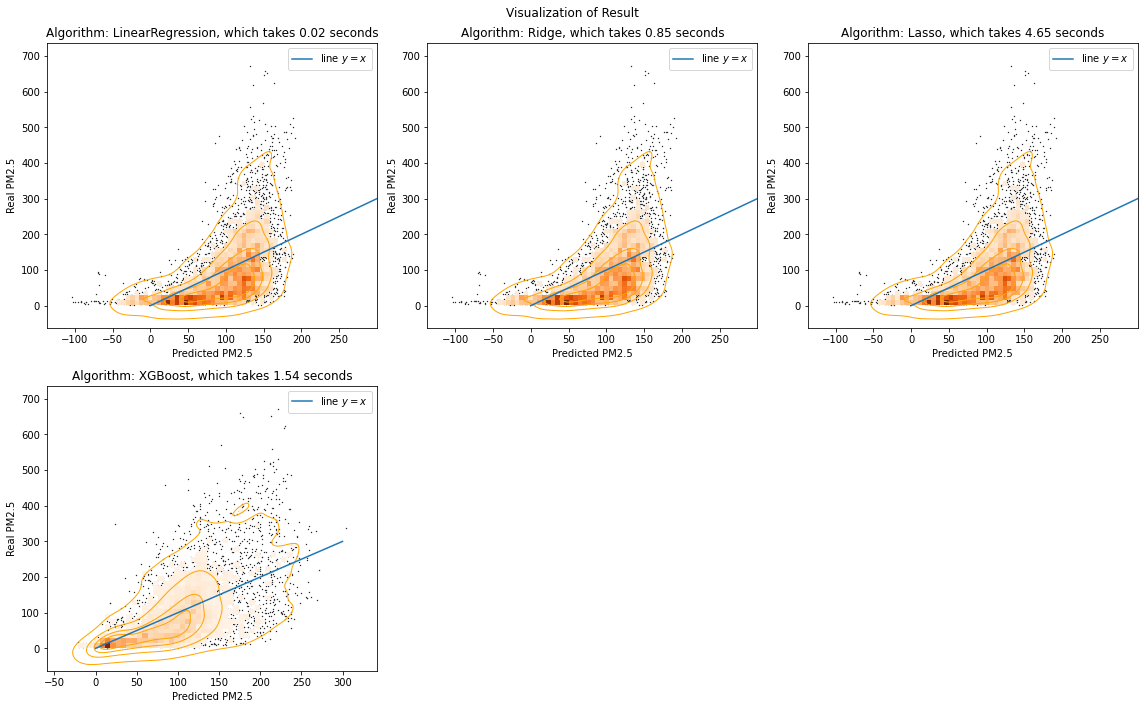

In [33]:
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

linear_model3=LinearRegression()
ridge_cv3=RidgeCV(alphas=np.arange(0.0001,0.001,0.0001),cv=10)
lasso_cv3=LassoCV(alphas=np.arange(0.01,10,0.01),cv=10)
xgb3=XGBRegressor(booster='gbtree',max_depth=3,n_estimators=200,learning_rate=0.1)

regression_algorithms={
    ('LinearRegression',linear_model3),
    ('Ridge',ridge_cv3),
    ('Lasso',lasso_cv3),
    ('XGBoost',xgb3)
}

result_KNN_df=fit_plot_result(regression_algorithms=regression_algorithms,\
                X_train=X_train_KNN_normalized_data,\
                y_train=y_train_KNN_data,
                X_test=X_test_normalized_data,
                y_test=y_test_data)

In [34]:
print('用KNN填补后模型的结果:\n{}.\n\
    原来的模型结果:\n{}'.format(result_KNN_df,result_df))

用KNN填补后模型的结果:
          Algorithm  Adj_R2 of test  R2 of train  R2 of test  MSE of test
0  LinearRegression        0.274424     0.251605    0.275631  6171.259346
1             Ridge        0.274424     0.251605    0.275631  6171.259387
2             Lasso        0.274389     0.251604    0.275596  6171.558440
3           XGBoost        0.405779     0.398407    0.406767  5054.045837.
    原来的模型结果:
          Algorithm  Adj_R2 of test  R2 of train  R2 of test  MSE of test
0           XGBoost        0.412286     0.407917    0.413264  4998.699426
1             Ridge        0.275152     0.257725    0.276358  6165.064424
2  LinearRegression        0.275288     0.257688    0.276494  6163.909507
3             Lasso        0.275072     0.257717    0.276278  6165.749472
4               SVR        0.289058     0.261381    0.290240  6046.795802


可以看到，通过KNN填补后的XGBoost算法的效果果然不如直接丢弃缺失值时训练的模型。这个结果与我们在使用KNN模型时候的论述相吻合。

## 特征的重要性


### 对特征重要性进行评级

我们使用三种评价特征重要性的标准，第一种是XGBoost算法中，通过影响分类的正确性能力得到的特征重要性；第二种是Lasso回归时，通过Lasso可以产生稀疏解的性质判断特征的重要性；第三种是用PCA，利用方差贡献程度来判断特征的重要性。

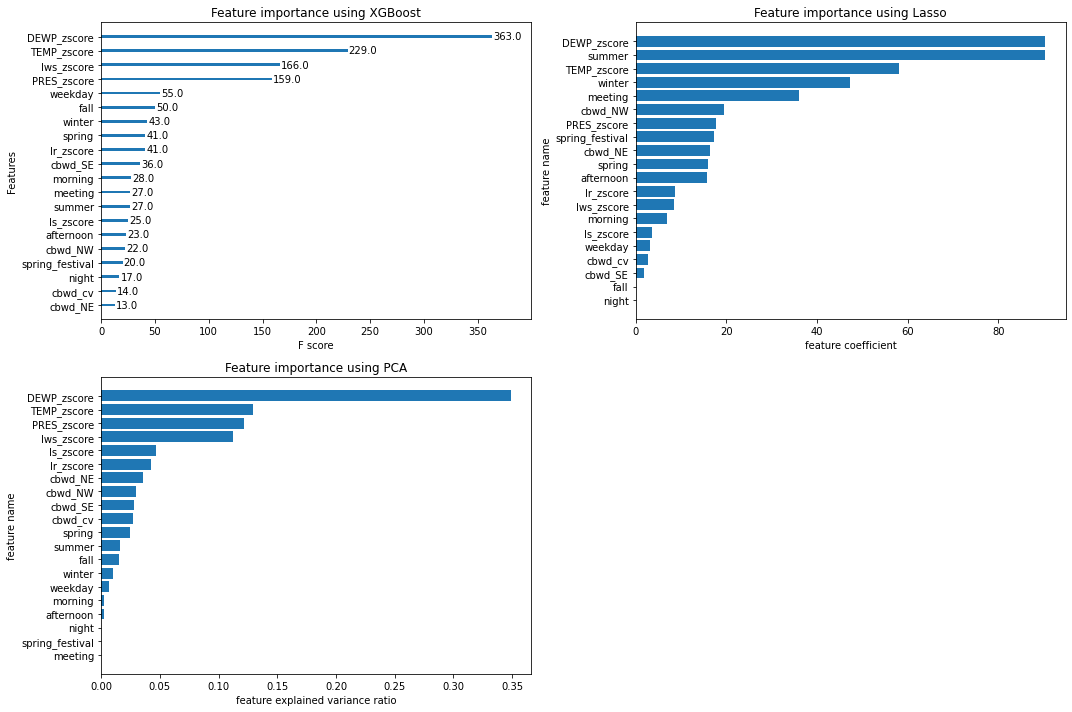

In [18]:
from xgboost import plot_importance
from sklearn.decomposition import PCA

fig=plt.figure(figsize=(15,10))
ax1=plt.subplot(2,2,1)
plot_importance(xgb,ax1,title='Feature importance using XGBoost',importance_type='weight',grid=False)

ax2=plt.subplot(2,2,2)
importance_sort_id2 = np.argsort(np.abs(lasso_cv.coef_))
n_feature = len(lasso_cv.feature_names_in_)
plt.barh(range(n_feature),np.abs(lasso_cv.coef_)[importance_sort_id2],align='center')
plt.yticks(range(n_feature),lasso_cv.feature_names_in_[importance_sort_id2])
plt.xlabel("feature coefficient")
plt.ylabel("feature name")
plt.title('Feature importance using Lasso')


pca = PCA().fit(X_train_plus_time_data)
importance_sort_id3 = np.argsort(np.abs(pca.explained_variance_ratio_))
n_feature = len(pca.feature_names_in_)
ax3=plt.subplot(2,2,3)
plt.barh(range(n_feature),np.abs(pca.explained_variance_ratio_)[importance_sort_id3],align='center')
plt.yticks(range(n_feature),pca.feature_names_in_[importance_sort_id3])
plt.xlabel("feature explained variance ratio")
plt.ylabel("feature name")
plt.title('Feature importance using PCA')

fig.tight_layout()
plt.show()

### 特征DEWP和TEMP重要性的模型选择解释和气象、人类活动解释

#### 1. 模型解释

我们选择在两个方法中都比较重要的特征，分别是：DEWP, TEMP. 对于时间相关的特征，比较重要的是“是否是冬天”。从最一开始对于PM2.5和特征的大概关系中，其实可以看出PM2.5和DEWP，Iws，Ir的相关性是比较强的，这点没有在Lasso方法中体现，而在XGBoost方法中体现了。这样从侧面说明了XGBoost回归效果较好的原因。



#### 2. 气象、人类活动解释
首先，我们需要了解PM2.5的来源，可以分成两类：自然形成和人类产出。自然形成包括：1. 从地表扬起的尘土，含有氧化物矿物和其他成分。2. 海盐是颗粒物的第2大来源，其组成与海水的成分类似。3. 还有一部分颗粒物是自然过程产生的，源自火山爆发、沙尘暴、森林火灾、浪花等。 人类产出包括：1. 由硫和氮的氧化物转化而成。而这些气体污染物往往是人类对化石燃料（煤、石油等）和垃圾的燃烧造成的。2. 没有先进废气处理装置的柴油汽车也是颗粒物的来源。


DEWP表示的是Dew Point（露点温度），即在固定气压之下，气态的$H_2O$达到饱和变成液态的温度；换言之，当温度低于露点温度时，水蒸气冷凝的速度大于蒸发的速度，此时气态水会转化为液态水，当温度高于露点温度时，水蒸气冷凝的速度小于蒸发的速度，此时液态水会转化为气态水。露点温度与温度、相对湿度有关，关系近似地由Magnus公式给出：
$$
\gamma(T,RH)=\ln{\frac{RH}{100}}+\frac{bT}{c+T};\quad T_{dp}=\frac{c\gamma(T,RH)}{b-\gamma(T,RH)},
$$
其中$T$时温度，$RH$是相对湿度，$a,b,c$是常数，取值通常为$a=6.11,b=18.678,c=257.14$. 这个公式定量的刻画了露点温度和温度与相对湿度的关系，我们这里只需要知道它与这两者有关即可。之所以露点温度对PM2.5的预测影响重要，就是因为温度和相对湿度对PM2.5的预测十分重要。

其中，温度（TEMP）的重要性在模型解释中已经体现。在物理上，温度对PM2.5的影响也是可解释的。原因是因为温度高时，高温会催化化学反应，而一部分PM2.5的形成正是硫和氮的氧化物分解得到的，因此温度对PM2.5是有影响的。我们再重新看一遍PM2.5关于月份和温度的关系图。


<AxesSubplot:xlabel='TEMP', ylabel='pm2.5'>

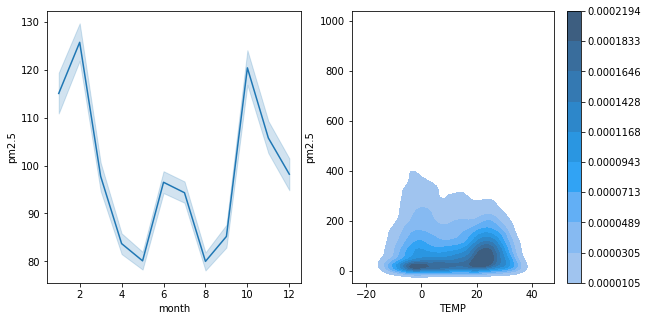

In [36]:
fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(1,2,1)
sns.lineplot(x=df['month'],y=df['pm2.5'])
ax2=plt.subplot(1,2,2)
sns.kdeplot(x=df['TEMP'],y=df['pm2.5'],cbar=True,shade=True)

从上右图中可以发现，当气温较高时PM2.5的浓度明显大于温度较低时。然而上右图中还可以发现，虽然在温度较低时PM2.5聚集在了较低的位置，然而却在较高位置有稀疏却比温度较高时值还高的点存在。这一点可以用人类活动来解释。当气温较低时，人类由于供暖需求需要燃烧大量的化石能源，因此会产生大量的PM2.5，造成PM2.5的异常值。

至于湿度对于PM2.5的影响，我们也提供一个物理解释。当空气湿度较大时，微粒容易与水蒸气结合形成液态水，从而不会悬浮于空气中。

因为湿度和温度对PM2.5的双重影响，露点温度成为了一个重要的影响PM2.5浓度的因素。

## Optional: 分类

在实际生活中，我们对于PM2.5的预测也许不需要那么精确，只需要知道其范围即可，于是我们将回归问题离散化为分类问题，这使得我们有更多可供选择的模型。

### 数据预处理

首先，我们将PM2.5的浓度等级进行划分，第一类为空气质量优，范围是0-35；第二类是良，范围35-135；第三类为差，范围为135以上。

In [65]:
def pmlevel(pm):
    if(pm<= 35):
        return 0
    if(35<=pm<=135):
        return 1
    if(pm>135):
        return 2


In [66]:
df['PM_Level'] = df.apply(lambda x: pmlevel(x['pm2.5']), axis=1)
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,summer,fall,winter,weekday,morning,afternoon,night,spring_festival,meeting,PM_Level
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,...,0,0,1,1,0,0,1,0,0,1
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,...,0,0,1,1,0,0,1,0,0,2
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,...,0,0,1,1,0,0,1,0,0,2
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,...,0,0,1,1,0,0,1,0,0,2
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,...,0,0,1,1,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,...,0,0,1,0,0,0,1,0,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,...,0,0,1,0,0,0,1,0,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,...,0,0,1,0,0,0,1,0,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,...,0,0,1,0,0,0,1,0,0,0


### 对数据进行平滑化处理

按照要求，我们对测试数据和训练数据都进行了平滑化处理（包括标签，PM2.5的值）。平滑化的方式直接的就是取数据前后的平均值，即将第$j$时刻的数据平滑化为$j-1,j,j+1$时刻数据的均值。

In [67]:
df_smooth=df.rolling(window=3).mean().dropna()
df_smooth['PM_Level'] = df.apply(lambda x: pmlevel(x['pm2.5']), axis=1)
X_train_normalized_smooth_data=df_smooth[df_smooth['test']==0].loc[:,name_plus_time_data]
X_test_normalized_smooth_data=df_smooth[df_smooth['test']==1].loc[:,name_plus_time_data]
y_train_label = df_smooth[df_smooth['test']==0].loc[:,'PM_Level']
y_test_label = df_smooth[df_smooth['test']==1].loc[:,'PM_Level']

### 模型评估方法

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


定义分类方法评估的函数,我们的评估方法使用了准确率（accuarcy），精度（precision），和召回率（recall)，F1 Score, $\kappa$ 系数。
其中$\kappa$系数的计算公式为
	$$
	\kappa =\frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{1-p_e},
	$$
	其中$p_o$是正确率，$p_e$是理论假设中预测成功的概率，算式为
	$$
	p_e=\sum_{c=1}^C\frac{n_c^{\text{pred}}}{N}\frac{n_c^{\text{true}}}{N},
	$$
	其中$n_c^{\text{pred}}$是样本中预测为$c$类的数量，$n_c^{\text{true}}$是样本中真实$c$类的数量。$\kappa$表示这两个指标的契合程度。一般$\kappa\geq 0.75$表示模型很好，$0<\kappa<0.4$表示模型一般，$\kappa<0$就比随机预测还要差了。

如同Part I一样，我们将模型训练和可视化的过程封装在了函数`fit_plot_Classify()`中。

### 分类模型：KNN, 朴素贝叶斯，SVM，LDA，XGBoost

我们使用五种分类方法。对于XGBoost，我们在回归模型中已经使用多次，对其最优参数比较熟悉，故省略了交叉验证的步骤。朴素贝叶斯方法没有什么需要调的参数；对于KNN算法，我们继续交叉验证的方法选取参数，需要选取的参数包括距离和`n_neighbors`.对于SVM，与之前的理由同样，由于其算法效率太低，我们无法通过交叉验证的方法进行参数选择，也不会是我们最终选择的模型；对于LDA，没有需要调整的参数。

In [107]:
'''from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
tuned_parameters = {'metric':['euclidean','manhattan'],'n_neighbors':range(30,40)}

clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5)
clf.fit(X_train_normalized_smooth_data,y_train_label)
clf.best_estimator_
'''

'''
Result:KNeighborsClassifier(metric='euclidean', n_neighbors=38)
'''

KNeighborsClassifier(metric='euclidean', n_neighbors=38)

In [125]:
from time import time
def fit_plot_Classify(regression_algorithms,X_train,y_train,X_test,y_test):
    result = pd.DataFrame(columns=['Algorithm','accuarcy','precision','recall','F1-score','kappa'])
    plot_num=1
    fig=plt.figure(figsize=(15,10))
    for name,algorithm in regression_algorithms:
        t0=time()
        algorithm.fit(X=X_train,y=y_train)
        y_pred=algorithm.predict(X_test)
        t1=time()
        accuarcy=accuracy_score(y_true=y_test,y_pred=y_pred)
        precision=precision_score(y_true=y_test,y_pred=y_pred,average='micro')
        recall=recall_score(y_true=y_test,y_pred=y_pred,average='micro')
        kappa = cohen_kappa_score(y_test,y_pred)
        F1_score = f1_score(y_test,y_pred,average='micro')
        result.loc[plot_num-1]=[name,accuarcy,precision,recall,F1_score,kappa]


        C=confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0, 1, 2])
        df=pd.DataFrame(C,index=["0-35", "35-135", "135-"],columns=["0-35", "35-135", "135-"])
        ax=plt.subplot(2,3,plot_num)
        sns.heatmap(df,cmap='Oranges',annot=True)
        ax.set_xlabel('predict') #x 轴
        ax.set_ylabel('true') #y 轴
        plt.title('Algorithm: {}, which takes {} seconds'.format(name,round(t1-t0,2)))
        plot_num+=1
    return result    


        
            

In [126]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

knn_model = KNeighborsClassifier(n_neighbors=38,metric='euclidean')
naive_bayes1 = GaussianNB()
lda= LinearDiscriminantAnalysis()
xgb=XGBClassifier(booster='gbtree',max_depth=3,n_estimators=200,learning_rate=0.1)
svc=SVC()



进行分类运算

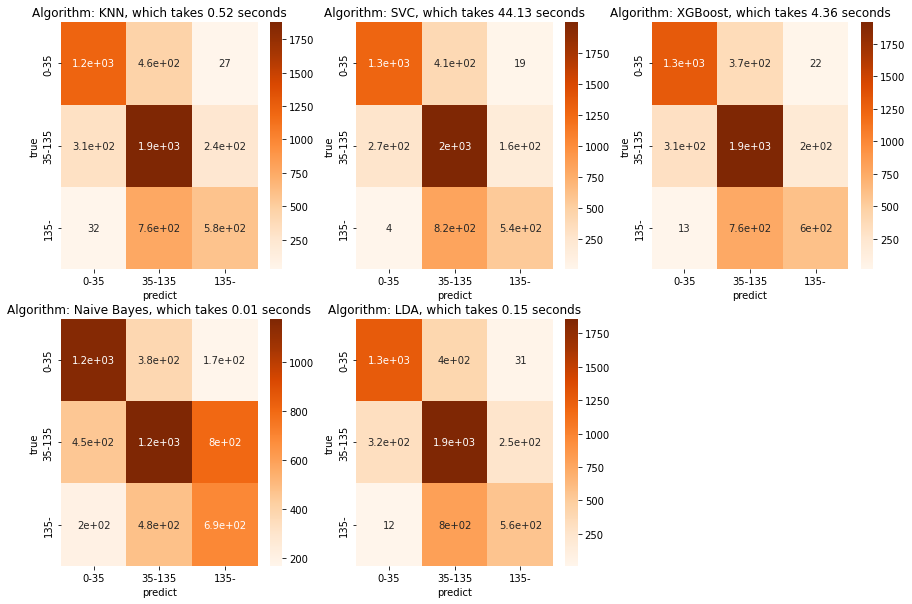

In [127]:
Classify_algorithms={
    ('KNN',knn_model),
    ('Naive Bayes',naive_bayes1),
    ('XGBoost',xgb),
    ('LDA',lda),
    ('SVC',svc)
    
}

result_classify=fit_plot_Classify(regression_algorithms=Classify_algorithms,\
                X_train=X_train_normalized_smooth_data,\
                y_train=y_train_label,
                X_test=X_test_normalized_smooth_data,
                y_test=y_test_label)


In [129]:
result_classify

,Algorithm,accuarcy,precision,recall,F1-score,kappa
0,KNN,0.667394,0.667394,0.667394,0.667394,0.468206
1,SVC,0.692853,0.692853,0.692853,0.692853,0.505430
2,XGBoost,0.695581,0.695581,0.695581,0.695581,0.514016
3,Naive Bayes,0.549009,0.549009,0.549009,0.549009,0.316590
4,LDA,0.669213,0.669213,0.669213,0.669213,0.471777


可以看到，朴素贝叶斯方法的表现欠佳，原因或许是因为朴素贝叶斯假设每个特征都是独立的，然而在我们的问题中，特征一定不是独立的（比如我们在特征分析中提到的DEWP和TEMP的相关性，以及时间特征中月份、是否是春节、是否在开会的相关性，等等），这或许导致其分类效果不佳。

### 分类模型总结

在分类模型中，模型与模型之间的效果区别并不大，除了朴素贝叶斯模型之外，其它四个模型都取得了不错的成绩。表现最好的模型是XGBoost和SVC，不过考虑到效率的缘故，我们最终选择XGBoost作为我们的分类模型。当然，还有一个不能忽略的模型是LDA，尽管它的得分没有那么高，但是相比于XGBoost所需要4.36秒完成模型建立和预测，LDA只需要惊人的0.15秒。因此，当数据量和特征维数足够大的时候（比如可以训练100年的数据），考虑到效率因素，LDA一定也是一个很好的备选项。

## 总结

在这次项目中，我们完整地使用了诸多机器学习的算法，包括监督学习和无监督学习。我们用的回归和分类模型都属于监督学习，在特征选择中，我们用的PCA方法属于无监督学习。在回归模型的搭建过程中，我们先直接利用天气数据进行回归（回归：Part I），然后再用时间的信息回归（回归：Part II），得到了更好的结果。在回归：Part III中，我们尝试使用填补数据缺失值的办法对问题进行重新回归。不过由于此问题的缺失值比较特殊，缺失的只有需要回归预测的PM2.5的数据，因此无论如何填补缺失值，都注定无法得到满意的结果。最后，我们将回归问题离散化为分类问题，通过分类模型进行预测。在转化为了分类问题之后，我们有更多的算法可以使用，添加了回归模型中没有使用过的朴素贝叶斯算法和LDA算法。尽管最后我们仍然选择了XGBoost算法，但是发现LDA算法能在极短的时间只能完成比较好的预测，这一点应该是我们从回归问题转为分类问题的一个好处。

在模型参数的选择上，对于有条件选取参数的模型，我们都利用了5折的交叉验证进行了参数选取，并且在测试集上得到了比较好的效果。


在模型评价上，对于回归问题，我们采用了三种评价标准，$R^2$ Score，adjusted $R^2$ score 和 MSE, 并且将adjusted $R^2$ score作为主要的评价指标；对于分类问题，我们采用了准确率（accuarcy），精度（precision），和召回率（recall)，F1 Score, $\kappa$ 系数作为评价指标，并且将$\kappa$系数作为了主要评价指标。并且依据主要评价指标，我们选择了回归、分类模型--均为XGBoost模型。该模型的结果可视化和模型评价分数都罗列在了回归和分类结果中，见图和表格。

我们在回归分析的最后给出了两个我们认为最重要的特征：DEWP和TEMP. 并从模型角度和气象、人类因素角度详细地给出了我们认为其重要的原因。